# QUEUE in TCP Algorithm

### Какие проблемы существуют у алгоритма Тахо?


Алгоритмы управления перегрузкой контролируют значения **окно перегрузки**, которое представляет собой количество пакетов, которые алгоритм управления перегрузкой будет держать при передаче в любой данный момент времени. Оптимальным значением окна перегрузки является **количество пакетов**, которые помещаются в канале, по которому происходит передача. Канал является BDP, то есть полосой пропускания, вычисленной как произведение задержки сети с полосой пропускания.

Тахо был разработан в 1988 году, и с тех пор многое изменилось в Интернете. Примечательно, что существует намного больше каналов с высоким показателем BDP, чем было тогда. Чтобы в полной мере воспользоваться каналами с высоким BDP, отправителям нужно отправлять сообщения с гораздо более высоким интервалом перегрузки. порогом канала 

Когда Tahoe перешагнул «порог медленного старта», он начинает линейно увеличивать размер окна перегрузки. Хотя это нормально для каналов с низким порогом канала BDP, для каналов с более высоким BDP требуется больше времени для конвергенции (сближения), и в итоге они не будут работать оптимально.

### Алгоритм CUBIC

Для эффективной работы в каналах с высокой пропускной способностью, нужно решить две основные проблемы:

1. Увеличевать значение окна перегрузки быстрее, чтобы все ресурсы канала (пропускная способность) были задействованы;
2. Не использовать быстрое увеличение окна.

Исходя из этих проблеи, то мы бы хотели бы иметь многофазный алгоритм, который поочередно исследует пропускную способность канала, а затем, как только доступная пропускная способность была обнаружена, медленно увеличивать этой значение до обнаруженной пропускной способности.

Есть функция, которая удовлетворяет «многофазному» требованию, кубическая функция:

![cubic function](cubic_function.png)

Алгоритм управления перегрузкой CUBIC состоит в том, что он имеет «вогнутую» фазу (до точки перегиба) и «выпуклую» фазу (после точки перегиба). Это начинается с быстрого роста значения окна перегрузки, оно замедляется после достижения значения `w_max`. Окно растет очень медленно вокруг значения `w_max`, и если не происходит потери пакетов, оно начинает быстро расти, чтобы исследовать большую полосу пропускания. Посли потери пакета, значение `w_max` устанавливается как размер окна перегрузки, когда произошла потеря.

### Начало работы:

В терминале вводим следующие команды:

```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
$ sudo sysctl -w net.core.rmem_default=26214400
$ sudo sysctl -w net.core.rmem_max=26214400
```

In [1]:
# импортируем необходимые библиотеки и модули для работы
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.plot_print_TCP_queue import run_mah_settings, open_tcp_port
from src.senders import Sender
from src.algorithm_average import SenderAlgorithm, FixedWindowAlgorithm, RENO_Algorithm, TAHOE_Algorithm, CUBIC_Algorithm

In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps.trace',
    '2.64MBPS': '2.64mbps.trace',
    '3.04MBPS': '3.04mbps.trace',
    '5.65MBPS': '5.65mbps.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}
# список временных меток по которым отправитель может отправлять 1500-байтовый пакет

# Запуск алгоритма Tahoe с низким значением BDP

Рассмотрим алгоритм Тахо по каналу 2,64 Мбит/с с задержкой 88 мс мы получаем:

* Пропускную способность
* Среднее значение круговой задержки RTT

Окно перегрузки уменьшается до 0 примерно при той же частоте, что и очередь в канале, достигая максимального размера 30 000 байтов.

[Отправитель] Подключен к получателю: 100.64.0.10:32783

Результаты для отправителя 39494, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 14016.000000
Среднее значение задержки RTT (мс): 243.996340



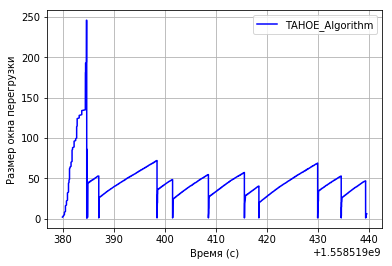

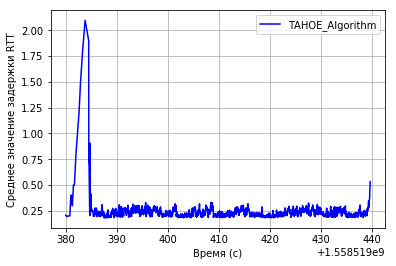

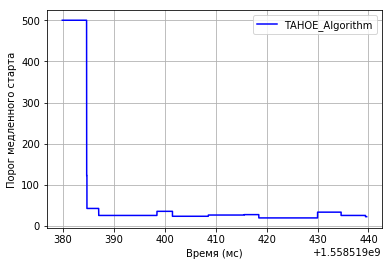

In [4]:
# Функция run_with_mahi_settings принимает некоторые параметры, в частности,
# параметры delay, trace_file и queue, а также количество секунд, в течение которых она должна работать,
# и алгоритм управления перегрузкой, а затем выводит некоторую статистику о том, что произошло.
# Это создает единую пару отправитель / получатель
mah_settings = {
    'delay': 88,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port = open_tcp_port()
algrtm = TAHOE_Algorithm(500, 1)
run_mah_settings(mah_settings, 60, [Sender(port, algrtm)])

# Запус алгоритма CUBIC с низким значением BDP

На этом канале с низким BDP CUBIC по-прежнему работает немного лучше, хотя и с немного худшими значением RTT.

* Пропускную способность
* Среднее значение круговой задержки RTT

Из этих графиков видно, что в алгоритме CUBIC больше не сбрасывается окно перегрузки до 0 после отбрасывания пакетов, а оно масштабируется константой beta_cubic (для которой в RFC рекомендуется использовать значение 0,7).

Алгоритм CUBIC принимает кубическую форму - он начинает быстро увеличиваться, затем сужается по мере приближения к тому месту, где появилось предыдущее падение, а затем начинает быстро расти, пробуя увеличить пропускную способность.

[Отправитель] Подключен к получателю: 100.64.0.10:49487

Результаты для отправителя 50155, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 23409.333333
Среднее значение задержки RTT (мс): 274.318141



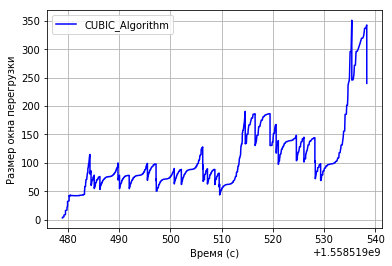

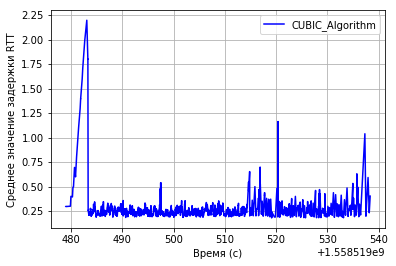

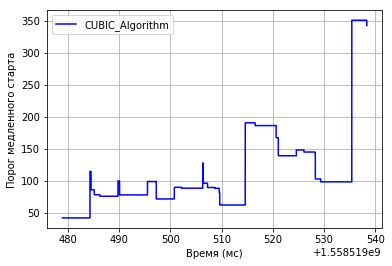

In [5]:
mah_settings = {
    'delay': 88,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port = open_tcp_port()
algrtm = CUBIC_Algorithm(4)
run_mah_settings(mah_settings, 60, [Sender(port, algrtm)])

# Запуск алгоритма Tahoe с высоким значением BDP

Окно перегрузки достигает примерно 100, прежде чем Тахо испытывает падение и снимает давление с очереди.

[Отправитель] Подключен к получателю: 100.64.0.10:53748

Результаты для отправителя 38896, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 16590.666667
Среднее значение задержки RTT (мс): 439.193529



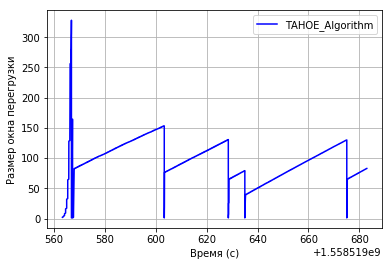

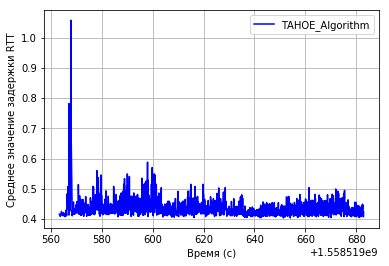

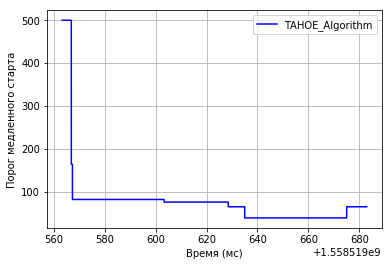

In [6]:
mah_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = open_tcp_port()
algrtm = TAHOE_Algorithm(500, 1)
run_mah_settings(mah_settings, 120, [Sender(port, algrtm)])

# Запус алгоритма CUBIC с высоким значением BDP

Мы видим, что при высоком значении BDP, алгоритм CUBIC действительно показывает лучший результат. Видим увеличение пропускной способности на 50% без значительного увеличения RTT (круговой задержки). В отличие от Tahoe, во время дропов пакетов, мы не так сильно отстаем, и когда мы это делаем, CUBIC увеличивает окно намного быстрее, поэтому использует гораздо больше преимуществ доступной полосы пропускания.

[Отправитель] Подключен к получателю: 100.64.0.12:39899

Результаты для отправителя 47735, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 23732.666667
Среднее значение задержки RTT (мс): 590.087180



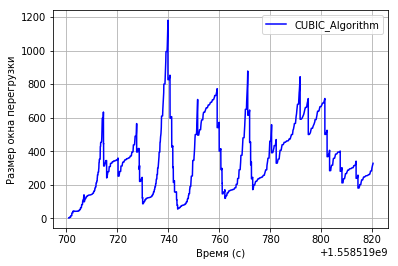

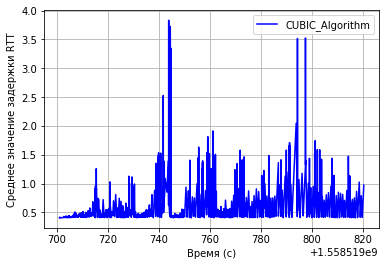

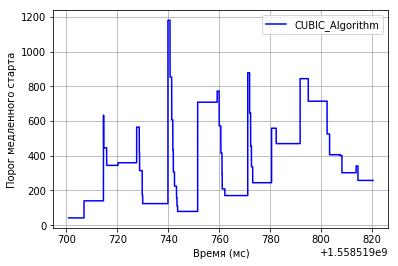

In [7]:
mah_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = open_tcp_port()
algrtm = CUBIC_Algorithm(4)
run_mah_settings(mah_settings, 120, [Sender(port, algrtm)])

# Сравнение - Tahoe vs Tahoe (с низким BDP)

Следующий вопрос - когда Tahoe и CUBIC размещены на одном и том же канале, справедливы ли они друг для друга? Другими словами, будет ли отправитель CUBIC занимать намного большую полосу пропускания, чем отправитель Tahoe?

Начнем с сравнения двух отправителей Тахо. Здесь мы видим, что они довольно справедливы по отношению друг к другу и достигают практически одинаковых результатов.

[Отправитель] Подключен к получателю: 100.64.0.14:42439

[Отправитель] Подключен к получателю: 100.64.0.14:42439

Результаты для отправителя 34866, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 13756.666667
Среднее значение задержки RTT (мс): 233.109024

Результаты для отправителя 45435, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 11932.000000
Среднее значение задержки RTT (мс): 233.787237



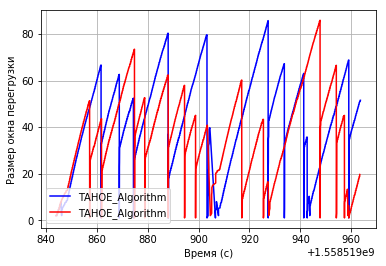

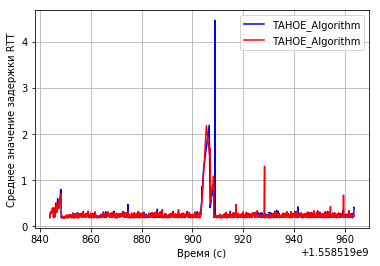

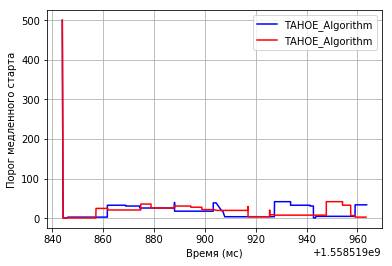

In [8]:
mah_settings = {
    'delay': 88,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = open_tcp_port()
algrtm1 = TAHOE_Algorithm(500, 1)
port2 = open_tcp_port()
algrtm2 = TAHOE_Algorithm(500, 1)
run_mah_settings(mah_settings, 120, [Sender(port1, algrtm1), Sender(port2, algrtm2)])

# Сравнение - CUBIC vs. Cubic (с высоким BDP)

Базовый показатель того, как работает CUBIC при запуске по одному и тому же каналу, что и другой отправитель CUBIC.
Они очень ровные и обеспечивают более высокую пропускную способность, чем один отправитель CUBIC, работающий в одиночку.

[Отправитель] Подключен к получателю: 100.64.0.14:60099

[Отправитель] Подключен к получателю: 100.64.0.14:60099

Результаты для отправителя 49120, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 13616.666667
Среднее значение задержки RTT (мс): 737.195232

Результаты для отправителя 48472, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 12287.333333
Среднее значение задержки RTT (мс): 664.823374



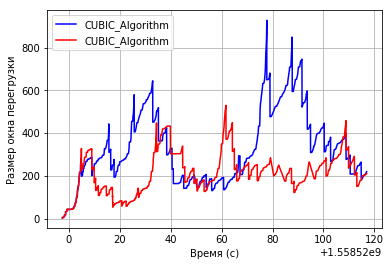

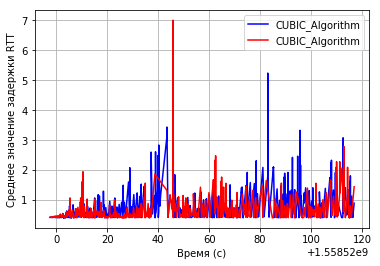

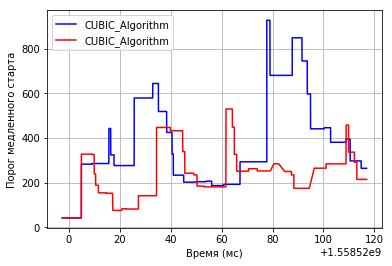

In [9]:
mah_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = open_tcp_port()
algrtm1 = CUBIC_Algorithm(4)
port2 = open_tcp_port()
algrtm2 = CUBIC_Algorithm(4)
run_mah_settings(mah_settings, 120, [Sender(port1, algrtm1), Sender(port2, algrtm2)])

# Сравнение - CUBIC vs. Tahoe (с низким BDP)

Сравнение алгоритмов CUBIC и Tahoe, работающих по одному и тому же каналу. Отправитель Тахо определенно отправляет пакет с более низкой пропускной способностью, чем это было раньше, но это не страшно. В целом, два отправителя вместе достигают более высокой пропускной способности, чем два отправителя Тахо.

CUBIC гораздо более агрессивен, чем Tahoe, мы ожидаем, что он довольно быстро увеличит использование полосы пропускания, особенно в периоды, когда Tahoe отступает после потери.

[Отправитель] Подключен к получателю: 100.64.0.14:43145

[Отправитель] Подключен к получателю: 100.64.0.14:43145

Результаты для отправителя 57818, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 19466.000000
Среднее значение задержки RTT (мс): 533.323922

Результаты для отправителя 44293, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 7297.333333
Среднее значение задержки RTT (мс): 235.566795



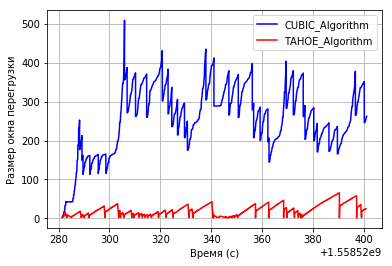

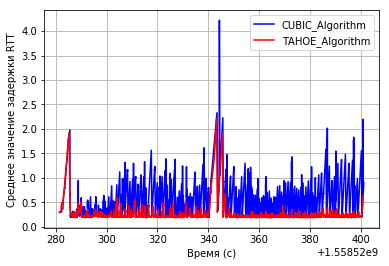

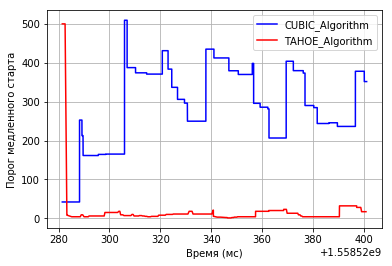

In [10]:
mah_settings = {
    'delay': 88,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = open_tcp_port()
algrtm1 = CUBIC_Algorithm(4)
port2 = open_tcp_port()
algrtm2 = TAHOE_Algorithm(500, 1)
run_mah_settings(mah_settings, 120, [Sender(port1, algrtm1), Sender(port2, algrtm2)])

# Сравнение - CUBIC vs. Tahoe (с высоким BDP)

Что происходит, когда мы выбираем высокое значение BDP?

Здесь разница между показателями CUBIC и Tahoe довольно резкая. Кроме того, что интересно, пропускная способность отправителя CUBIC здесь намного выше, чем когда он работал самостоятельно.

Это можно понять по графику перегрузок - поскольку CUBIC очень агрессивен, он видит свое первое падение намного позже, когда он просто работает сам по себе. Когда он бежит рядом с Тахо, он видит свои падения раньше, потому что есть другой отправитель, блокирующий очередь. Более ранние падения означают, что порог медленного старта возрастает медленнее, и позволяет CUBIC достичь более высокой пропускной способности.

А работа алгоритма Tahoe прекращается, когда происходит потеря сразу нескольких пакетов подряд.

[Отправитель] Подключен к получателю: 100.64.0.14:48615

[Отправитель] Подключен к получателю: 100.64.0.14:48615

Результаты для отправителя 40083, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 18232.666667
Среднее значение задержки RTT (мс): 697.634272

Результаты для отправителя 56437, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 4771.333333
Среднее значение задержки RTT (мс): 446.881840



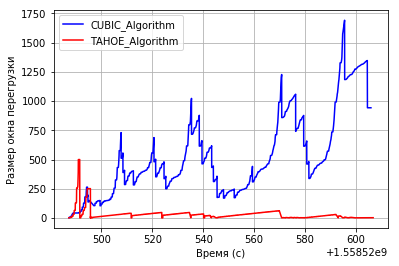

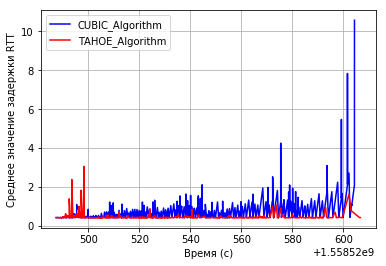

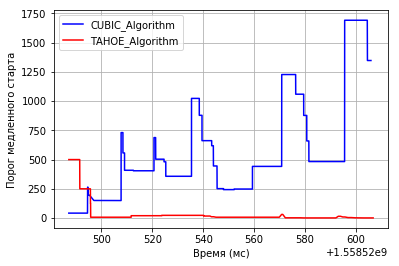

In [12]:
mah_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = open_tcp_port()
algrtm1 = CUBIC_Algorithm(4)
port2 = open_tcp_port()
algrtm2 = TAHOE_Algorithm(500, 1)
run_mah_settings(mah_settings, 120, [Sender(port1, algrtm1), Sender(port2, algrtm2)])

### Алгоритм Reno

TCP Reno был разработан в 1990 году. Особенностью данного алгоритма является циклическое изменение размера окна при нормальных условиях, пока не произойдет потеря сегмента. TCP Reno находится в фазе медленного старта, когда размер окна меньше определенного граничного значения числа сегментов, при котором происходит переход на фазу исключения перегрузки. В фазе медленного старта при получении квитанции, подтверждающей доставку, окно увеличивается на единицу. В фазе же исключения перегрузки в той же ситуации получения квитанции окно увеличивается на величину, обратную самому себе. Если во время таймаута удается обнаружить потерю сегмента, то пороговое число сегментов становится равным половине размера окна в данный момент, а размер окна становится равным единице (при использовании алгоритма быстрой повторной передачи размер окна становится равным новому пороговому числу сегментов). Сразу после этого происходит переход в фазу быстрого восстановления, в которой размер окна увеличивается на единицу только тогда, когда приходит дублированное подтверждение. Если же приходит недублированный отклик от сегмента, отправленного повторно, то размер окна становится равным пороговому числу сегментов. При таймауте в данной фазе значения размера окна и порогового числа сегментов обновляются, как при потере сегмента.

[Отправитель] Подключен к получателю: 100.64.0.22:38583

Результаты для отправителя 60383, с алгоритмом: RENO_Algorithm
Пропускная способность (бит/с): 50945.333333
Среднее значение задержки RTT (мс): 166.489522



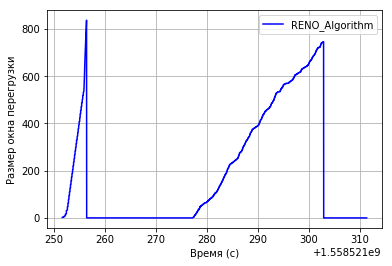

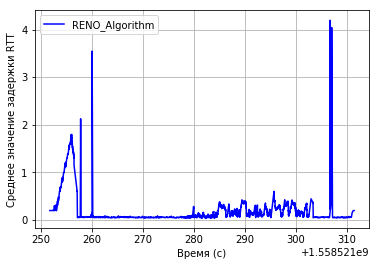

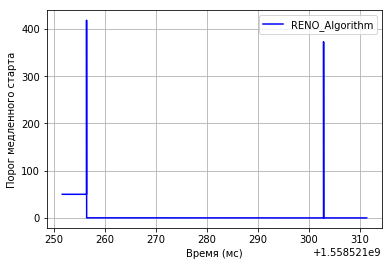

In [6]:
mah_settings = {
    'delay': 20,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = open_tcp_port()
algrtm1 = RENO_Algorithm(50, 1)
run_mah_settings(mah_settings, 60, [Sender(port1, algrtm1)])

[Отправитель] Подключен к получателю: 100.64.0.20:33269

[Отправитель] Подключен к получателю: 100.64.0.20:33269

[Отправитель] Подключен к получателю: 100.64.0.20:33269

Результаты для отправителя 53535, с алгоритмом: CUBIC_Algorithm
Пропускная способность (бит/с): 24886.666667
Среднее значение задержки RTT (мс): 315.652629

Результаты для отправителя 42248, с алгоритмом: TAHOE_Algorithm
Пропускная способность (бит/с): 15349.333333
Среднее значение задержки RTT (мс): 82.856593

Результаты для отправителя 44922, с алгоритмом: RENO_Algorithm
Пропускная способность (бит/с): 3796.000000
Среднее значение задержки RTT (мс): 262.609538



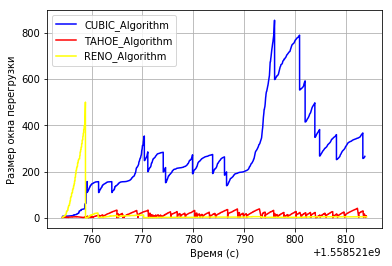

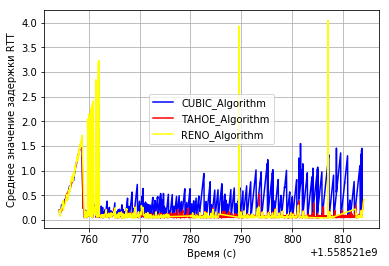

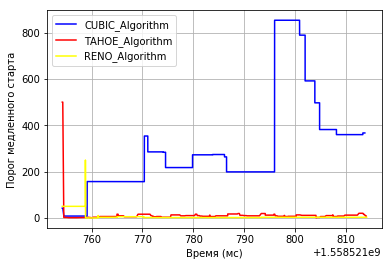

In [5]:
mah_settings = {
    'delay': 20,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = open_tcp_port()
algrtm1 = CUBIC_Algorithm(4)
port2 = open_tcp_port()
algrtm2 = TAHOE_Algorithm(500, 1)
port3 = open_tcp_port()
algrtm3 = RENO_Algorithm(50, 1)
run_mah_settings(mah_settings, 60, [Sender(port1, algrtm1), Sender(port2, algrtm2), Sender(port3, algrtm3)])